<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/FDM_FEM_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Original source:
# Introduction to finite element methods
# Hans Petter Langtangen
# Link: http://hplgit.github.io/INF5620/doc/pub/main_fem.pdf
# http://hplgit.github.io/INF5620/doc/pub/H14/fem/html/._main_fem-solarized003.html

def least_squares(f, psi, Omega):
    N = len(psi) - 1
    A = sp.zeros(N+1, N+1)
    b = sp.zeros(N+1, 1)
    x = sp.Symbol('x')
    for i in range(N+1):
        for j in range(i, N+1):
            A[i,j] = sp.integrate(psi[i]*psi[j],
                                  (x, Omega[0], Omega[1]))
            A[j,i] = A[i,j]
        b[i,0] = sp.integrate(psi[i]*f, (x, Omega[0], Omega[1]))
        c = A.LUsolve(b)
        u=0
    for i in range(len(psi)):
        u += c[i,0]*psi[i]
    return u
  
def interpolation(f, psi, points):
    N = len(psi) - 1
    A = sp.zeros(N+1, N+1)
    b = sp.zeros(N+1, 1)
    x = sp.Symbol('x')
    # Turn psi and f into Python functions
    psi_vals = [sp.lambdify([x], psi[i]) for i in range(N+1)]
    f = sp.lambdify([x], f)
    for i in range(N+1):
        for j in range(N+1):
            A[i,j] = psi_vals[j](points[i])
        b[i,0] = f(points[i])
    c = A.LUsolve(b)
    u=0
    for i in range(len(psi)):
        u += c[i,0]*psi_vals[i](x)
    return u

[1, 2]


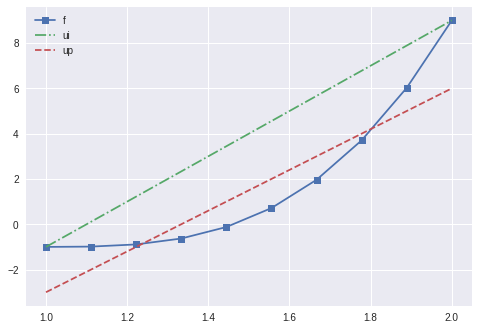

In [0]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt


x = sp.Symbol('x')
f = 10*(x-1)**3-1
psi=[1, x]
a, b = 1, 2

up = least_squares(f, psi, Omega=[a, b])

points = [a,b]
ui = interpolation(f, psi, points)

lam_f = sp.lambdify(x, f, modules=['numpy'])
lam_ui = sp.lambdify(x, ui, modules=['numpy'])
lam_up = sp.lambdify(x, up, modules=['numpy'])


x_vals = np.linspace(1, 2, 10)
f_vals = lam_f(x_vals)
ui_vals = lam_ui(x_vals)
up_vals = lam_up(x_vals)

plt.figure(1)
plt.plot(x_vals, f_vals,'-s',x_vals, ui_vals,'-.', x_vals, up_vals,'--')
plt.gca().legend(('f','ui','up'))

print(points)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


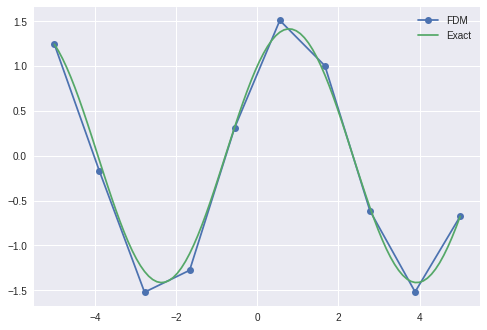

In [93]:
def FDM(lam_f, a, b, N, lam_ue):
# Solving -u''=f in (a, b) by Finite Difference Method 
# Dirichlet boundary conditions at two ending points
# Van-Dang Nguyen 2019  
  xd= np.linspace(a, b, num=N)
  # Grid size
  h=xd[1]-xd[0]
  ones=np.ones(N)

  # Create left-hand side digonal matrix [1 -2 1]
  data = -1/(h*h)*np.array([ones,-2*ones,ones])
  diags = np.array([-1, 0, 1])
  A=spdiags(data, diags, N, N,format="csr").toarray()
   
  # Boundary conditions for the left-hand side 
  A[0,:] = 0; # zero out row 0 corresponding to x=a.
  A[0,0]=1
  A[N-1,:]=0; # zero out row N-1 corresponding to x=b.
  A[N-1,N-1]=1
 
  # Boundary conditions for the right-hand side  
  rhs = lam_f(xd); # rhs = source 
  rhs[0], rhs[N-1]=lam_ue(xd[0]), lam_ue(xd[N-1]) # Dirichlet values
  
  ## solving the linear system
  u= spsolve(A, rhs, permc_spec=None, use_umfpack=True)
  return xd, u

import sympy as sp
import numpy as np
from scipy.sparse import spdiags
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
 
# N discrete points of [a, b]
a, b, N = -5.0, 5.0, 10; 

# Compute the source based on a given exact solution
x = sp.Symbol('x')
ue = sp.cos(x)+sp.sin(x)
f = -sp.diff(ue, x, 2);
lam_f = sp.lambdify(x, f, modules=['numpy'])
lam_ue = sp.lambdify(x, ue, modules=['numpy'])
    
xd, u = FDM(lam_f, a, b, N, lam_ue)  
xe = np.linspace(a, b, 100)
ue = lam_ue(xe)

plt.plot(xd, u,'-o',xe, ue,'-')
plt.gca().legend(('FDM','Exact'))

